In [1]:
import sys
import timeit
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

sys.path.append('../gmm_modules/')
from data_preparation import get_train_test_data, get_gen_data, get_train_data_for_NN
from metrics import metric_boxplot, eval_metrics, dump_metrics

np.random.seed(10)
%matplotlib inline

## Подготовим данные

In [2]:
%%time
path_to_dataset = '../../../SUSY.csv'
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
train_size = 400000
test_size = 100000

X_train, X_test, y_train, y_test = get_train_test_data(path_to_dataset, column_names, train_size, test_size)

CPU times: user 36.1 s, sys: 8.43 s, total: 44.5 s
Wall time: 49.3 s


In [3]:
# split X_train by class
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]  

In [4]:
X_good.shape, X_bad.shape, X_train.shape, X_test.shape

((200000, 18), (200000, 18), (400000, 18), (100000, 18))

## Сгенерируем примеры используя GMM подход

In [7]:
import os
# import h5py
# import shutil
import numpy as np
import pandas as pd

from math import ceil
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
def get_XW(X_good, n_samples, n_components, sigma=0.01):
    # calculate GMM
    gm = GaussianMixture(n_components=n_components, n_init=4, covariance_type="full", verbose=0)
    gm.fit(X_good + np.random.normal(0, sigma, X_good.shape))
    print("BIC: ", gm.bic(X_good))

    # generate data
    X_gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                             size=ceil(gm.weights_[0] * n_samples)))
    for d in range(1, gm.n_components):
        X_gen=np.vstack((
            X_gen, 
            multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=ceil(gm.weights_[d]*n_samples))
        ))
    X_gen = np.random.permutation(X_gen)[:n_samples]

    # weights ~ 1/max_proba
    probas = np.empty((gm.n_components, X_gen.shape[0]))
    for d in range(gm.n_components):
        probas[d] = multivariate_normal.pdf(
            X_gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True
        )
    maxprob = np.max(probas, axis=0)
    w_gen = 1./(maxprob + 1e-2)
    return X_gen, w_gen

### n_components = 5

In [9]:
%%time
n_components = 5
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  1756987.4549180653
CPU times: user 1min 32s, sys: 22.3 s, total: 1min 55s
Wall time: 1min 36s


In [ ]:
components = [5, 15, 35, 60, 100, 200, 500]
bics = [1756987.4549180653, ]

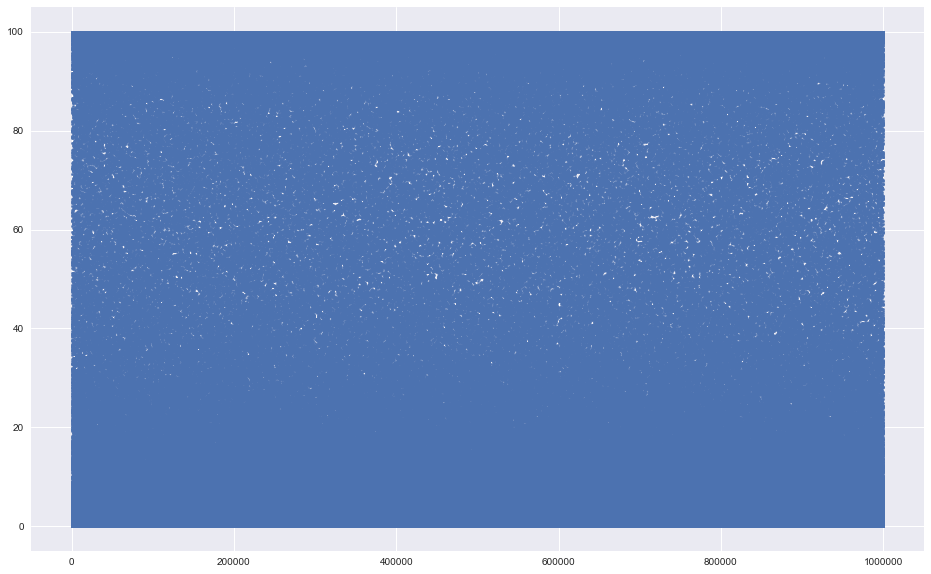

In [13]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

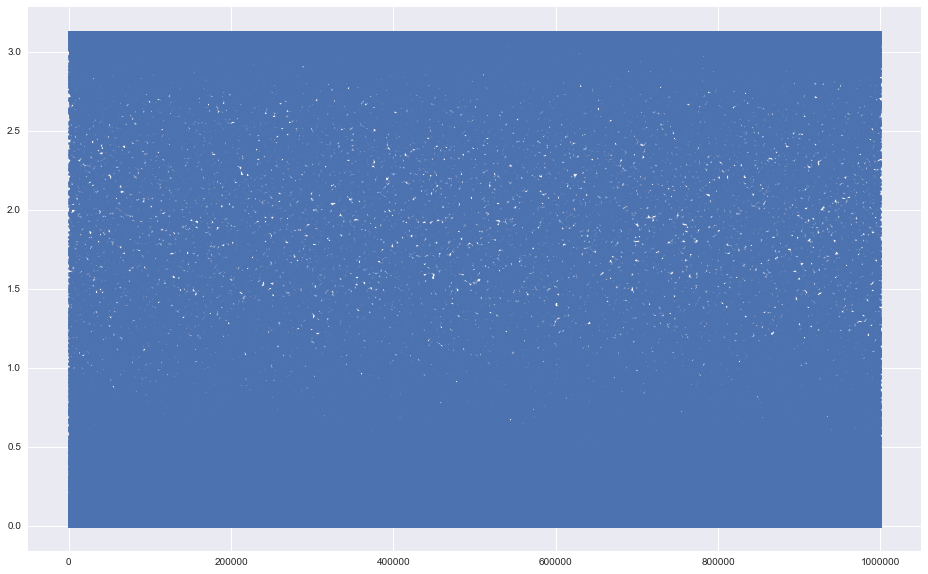

In [14]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [21]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.298548, 0.701452)

In [22]:
max(w_gen), min(w_gen)

(99.99999999999889, 5.056281789058596e-05)

In [23]:
np.mean(w_gen), np.std(w_gen)

(32.000702190950726, 39.06158539185393)

Проанализируем нормированные веса

In [24]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.353535, 0.646465)

In [25]:
max(w_gen_norm), min(w_gen_norm)

(3.124931428169637, 1.5800533872311181e-06)

In [26]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000004, 1.2206477582513768)

### n_components = 15

In [27]:
%%time
n_components = 15
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  671233.2123981108
CPU times: user 8min 19s, sys: 45.5 s, total: 9min 5s
Wall time: 8min 41s


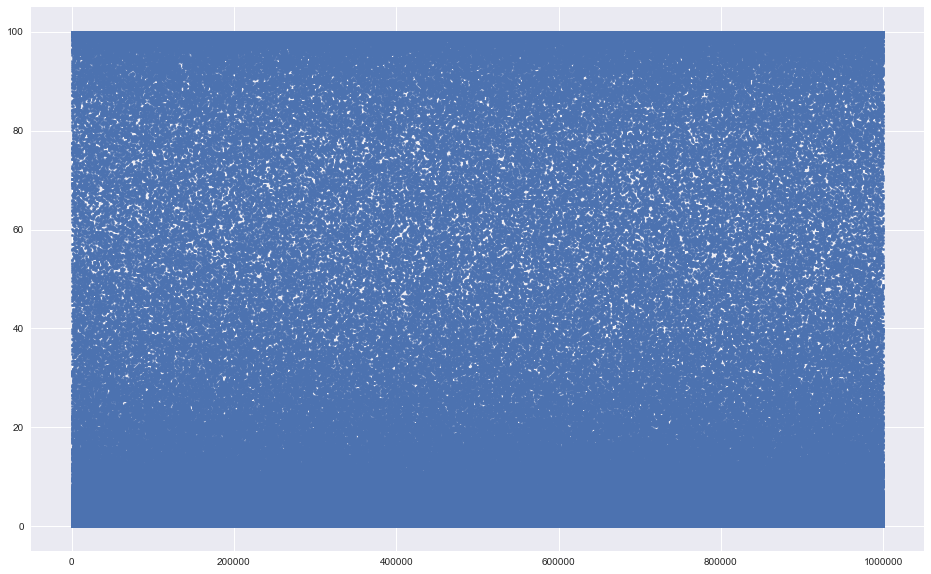

In [28]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

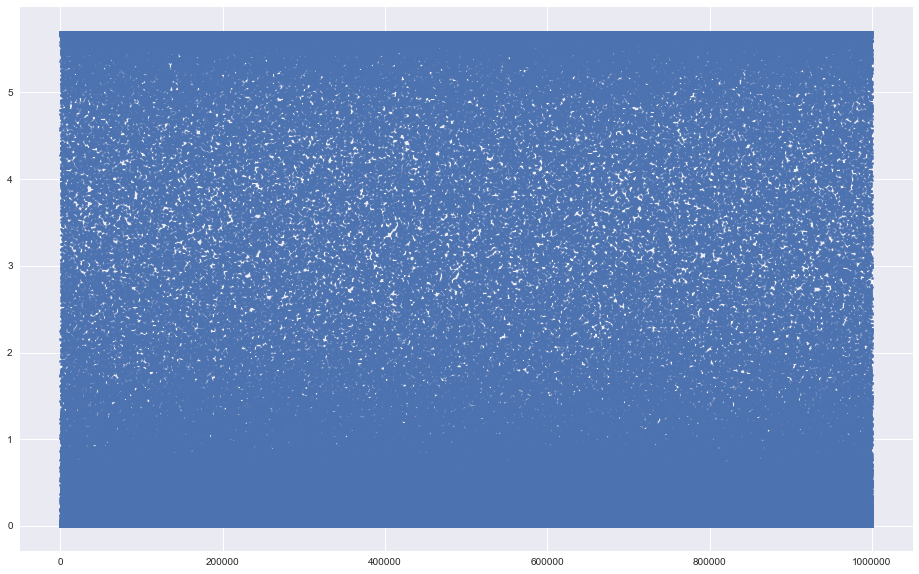

In [29]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [30]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.161283, 0.838717)

In [31]:
max(w_gen), min(w_gen)

(99.99999999999194, 6.276660026605479e-07)

In [32]:
np.mean(w_gen), np.std(w_gen)

(17.556436219757156, 32.245025272390535)

Проанализируем нормированные веса

In [33]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.235922, 0.764078)

In [34]:
max(w_gen_norm), min(w_gen_norm)

(5.695916799302174, 3.5751333289053465e-08)

In [35]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000002, 1.8366498114294716)

### n_components = 35

In [36]:
%%time
n_components = 35
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  -151447.20195683851
CPU times: user 26min 19s, sys: 4min 42s, total: 31min 1s
Wall time: 29min 52s


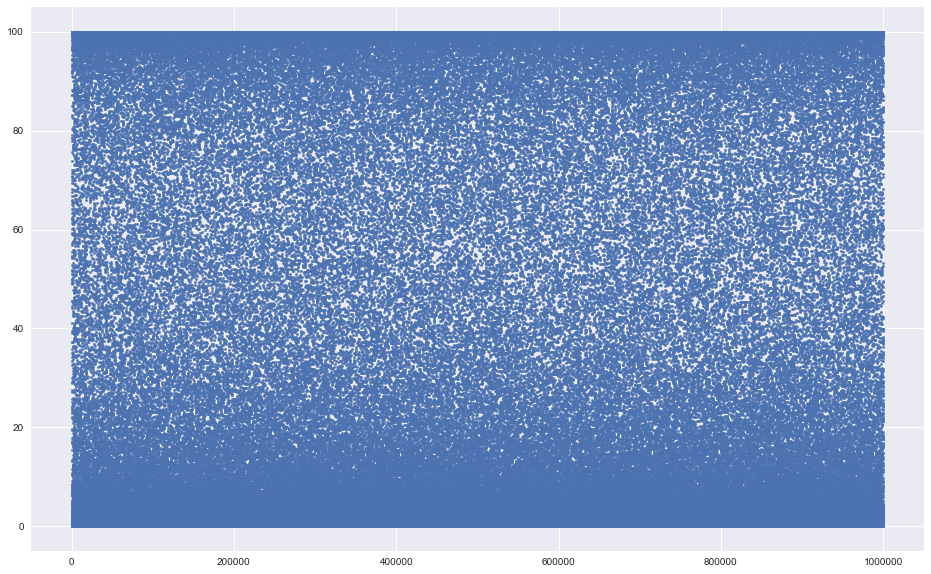

In [37]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

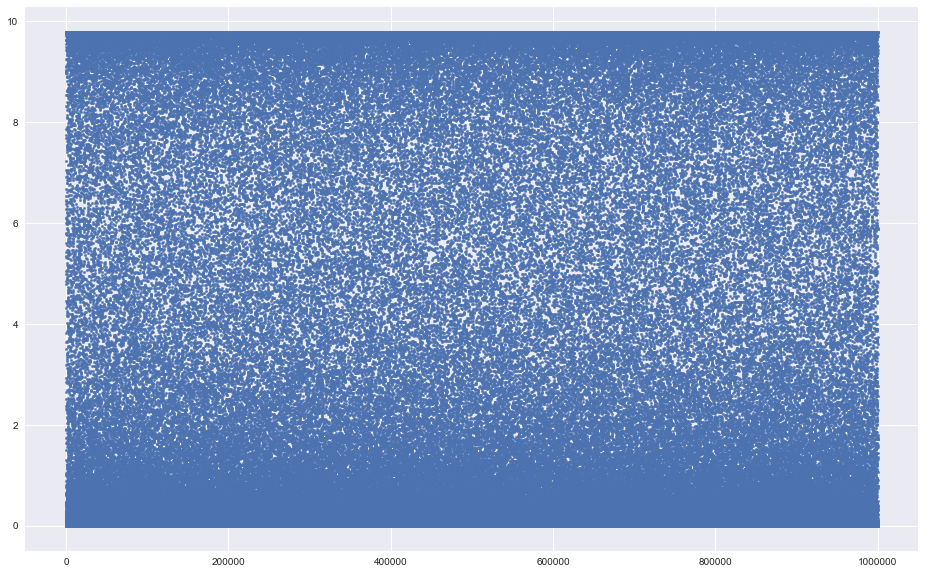

In [38]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [39]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.095803, 0.904197)

In [40]:
max(w_gen), min(w_gen)

(99.99999999999821, 2.1342842480540383e-08)

In [41]:
np.mean(w_gen), np.std(w_gen)

(10.213377440276933, 26.482869888016932)

Проанализируем нормированные веса

In [42]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.151181, 0.848819)

In [43]:
max(w_gen_norm), min(w_gen_norm)

(9.791080431987515, 2.0896948737421457e-09)

In [44]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(0.9999999999999996, 2.592959091434387)

### n_components = 60

In [45]:
%%time
n_components = 60
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  -672929.9494915995
CPU times: user 47min 44s, sys: 6min 59s, total: 54min 43s
Wall time: 52min 23s


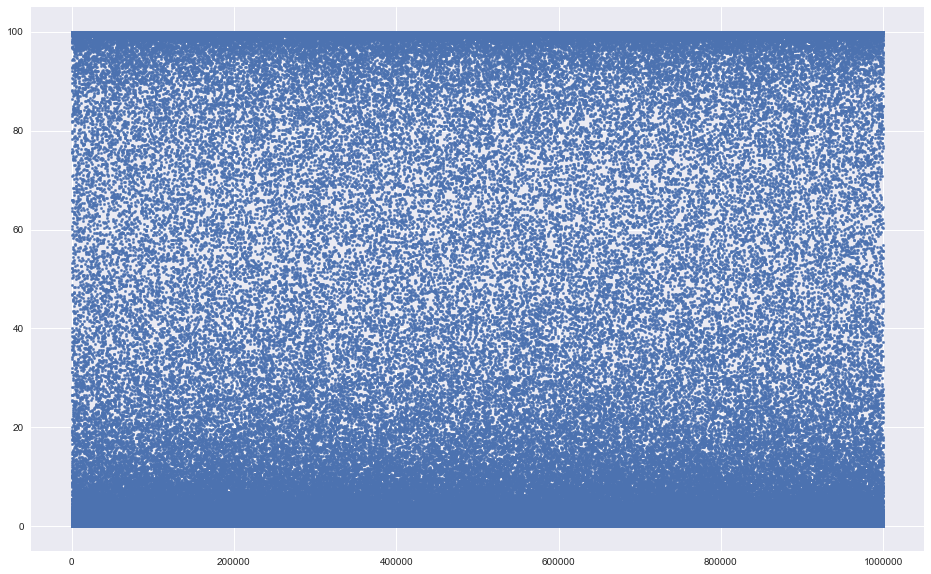

In [46]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

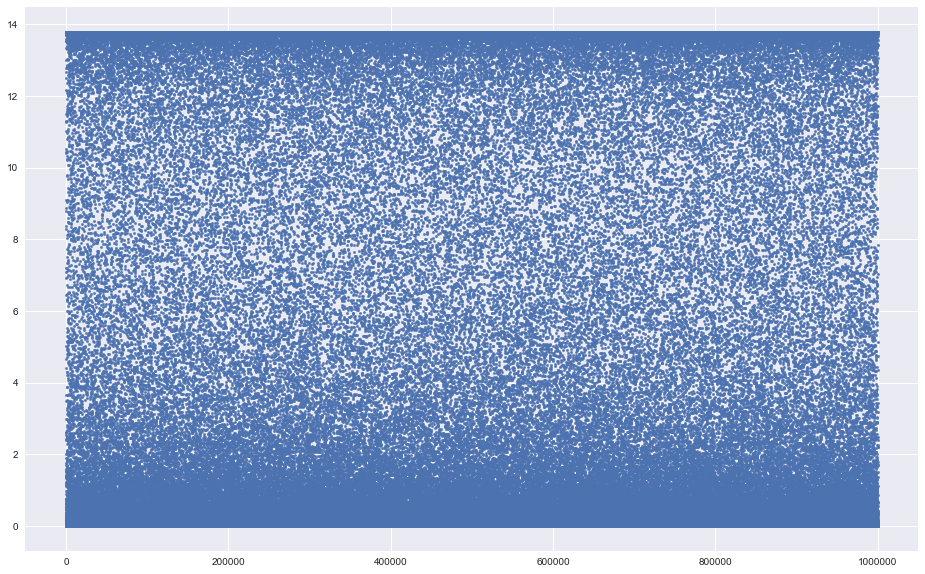

In [47]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [48]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.067297, 0.932703)

In [49]:
max(w_gen), min(w_gen)

(99.99999999998947, 2.735135716289173e-09)

In [50]:
np.mean(w_gen), np.std(w_gen)

(7.253122546855339, 22.915708318015657)

Проанализируем нормированные веса

In [51]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.114417, 0.885583)

In [52]:
max(w_gen_norm), min(w_gen_norm)

(13.787165369671774, 3.770976842897846e-10)

In [53]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(0.9999999999999997, 3.159426601436783)

### n_components = 100

In [55]:
%%time
n_components = 100
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  -1156253.975190586
CPU times: user 1h 21min 52s, sys: 14min 30s, total: 1h 36min 23s
Wall time: 1h 40min 46s


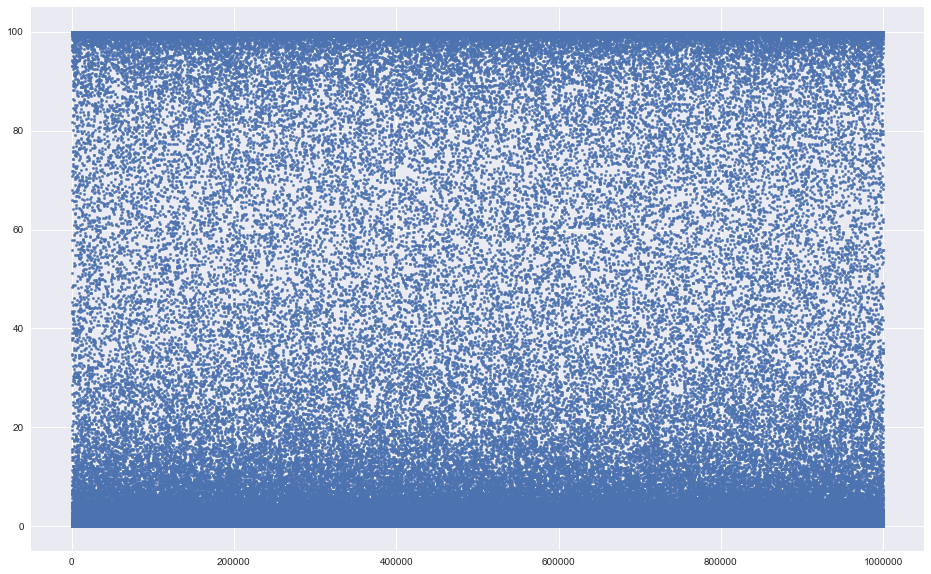

In [56]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

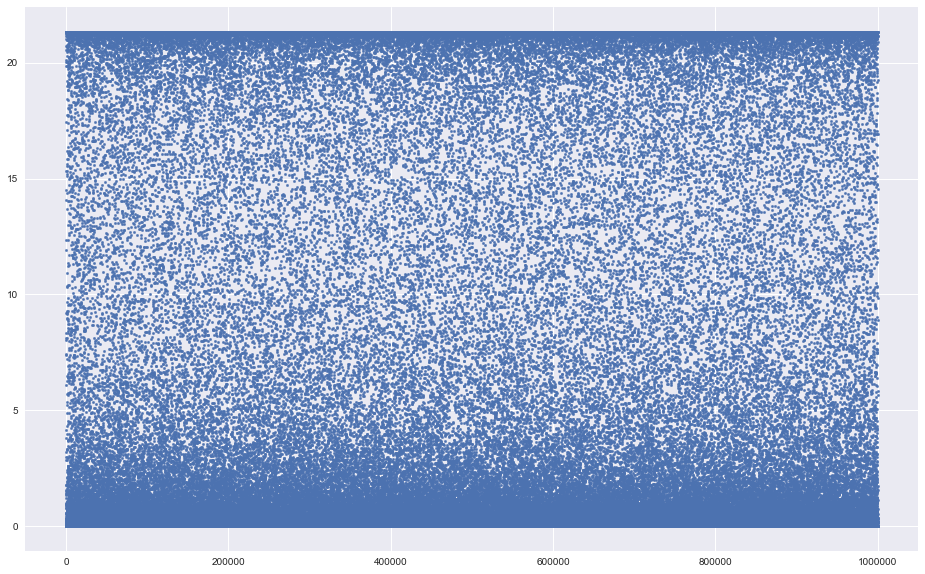

In [57]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [58]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.043227, 0.956773)

In [59]:
max(w_gen), min(w_gen)

(99.99999999969141, 4.107637737115995e-10)

In [60]:
np.mean(w_gen), np.std(w_gen)

(4.687447643109689, 18.68886098402279)

In [98]:
1/4.687447643109689

0.21333571618020086

Проанализируем нормированные веса

In [61]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.082587, 0.917413)

In [62]:
max(w_gen_norm), min(w_gen_norm)

(21.333571617954252, 8.763058384564604e-11)

In [63]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000002, 3.9870015426187164)

In [64]:
path_to_gen_file = './gen_data/gen_100.npz'
np.savez(path_to_gen_file, X_gen=X_gen, w_gen=w_gen_norm)

### n_components = 200

In [65]:
%%time
n_components = 200
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 4 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BIC:  -1673064.810853648
CPU times: user 3h 21min 54s, sys: 32min 41s, total: 3h 54min 35s
Wall time: 4h 7min


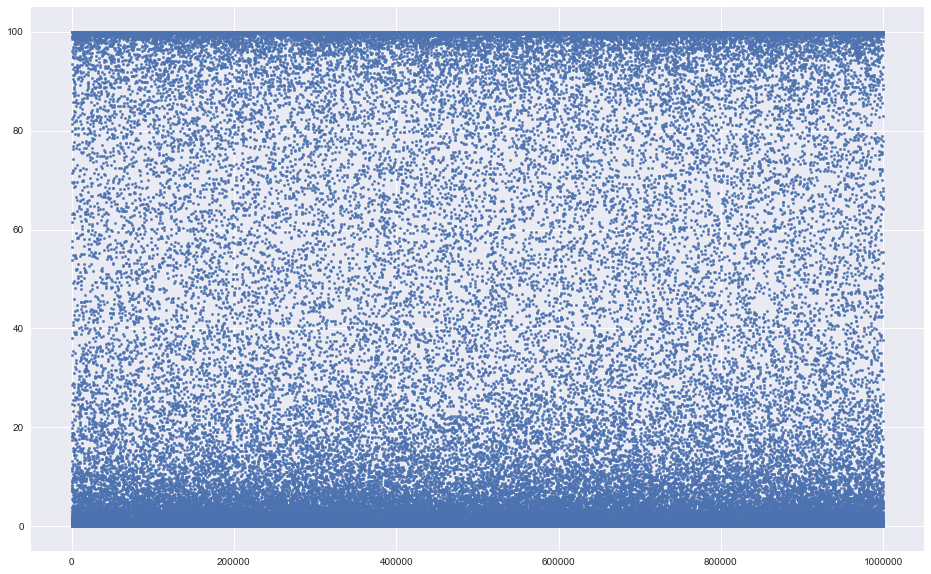

In [66]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

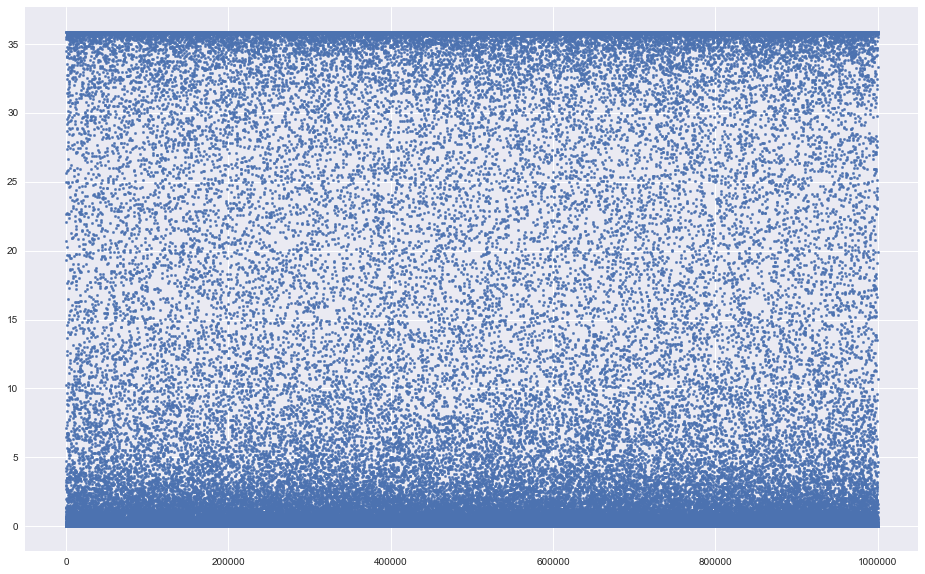

In [67]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [68]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.026049, 0.973951)

In [69]:
max(w_gen), min(w_gen)

(99.99999999940482, 3.645751649069999e-11)

In [70]:
np.mean(w_gen), np.std(w_gen)

(2.7866649440827373, 14.697907861932032)

In [97]:
1/2.7866649440827373

0.3588518964662117

Проанализируем нормированные веса

In [71]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.053097, 0.946903)

In [72]:
max(w_gen_norm), min(w_gen_norm)

(35.88518964640758, 1.3082848933135876e-11)

In [73]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000009, 5.274372110339951)

In [74]:
path_to_gen_file = './gen_data/gen_200.npz'
np.savez(path_to_gen_file, X_gen=X_gen, w_gen=w_gen_norm)

### n_components = 500

In [75]:
%%time
n_components = 500
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 4 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BIC:  -1996025.6841273129
CPU times: user 8h 40min 5s, sys: 1h 22min 46s, total: 10h 2min 52s
Wall time: 10h 39min 51s


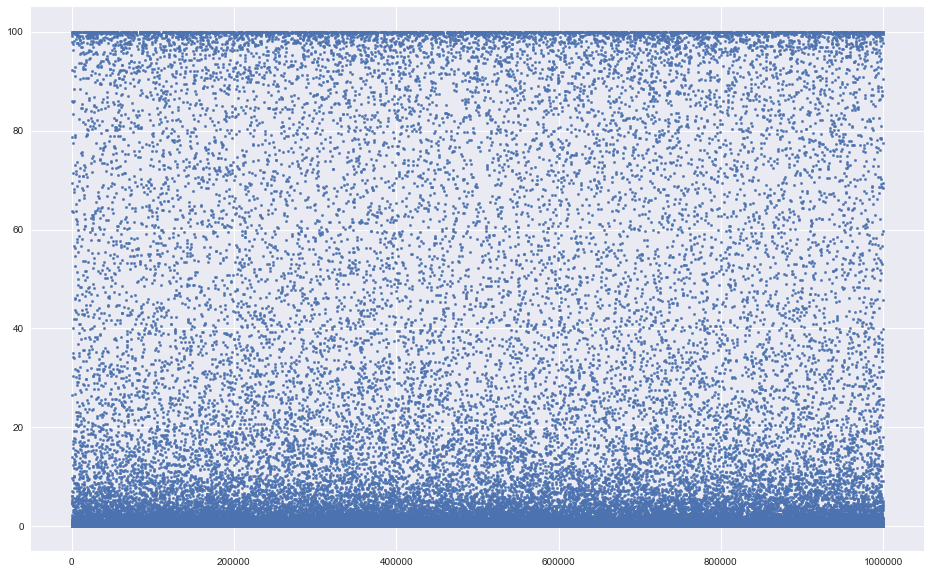

In [76]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

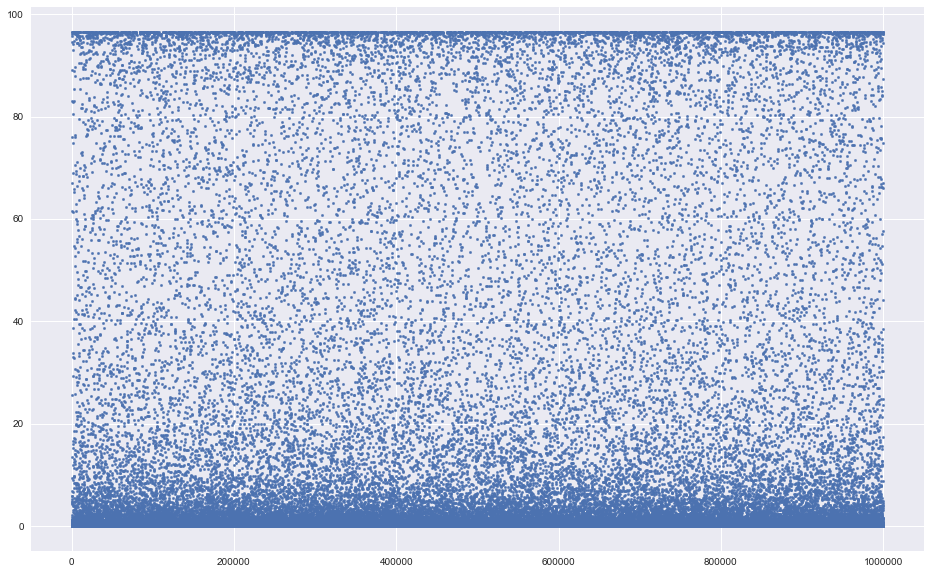

In [77]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [78]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.009139, 0.990861)

In [79]:
max(w_gen), min(w_gen)

(99.9999999262768, 7.009199056523265e-33)

In [80]:
np.mean(w_gen), np.std(w_gen)

(1.035851377132924, 8.536254074278835)

Проанализируем нормированные веса

In [81]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.031693, 0.968307)

In [82]:
max(w_gen_norm), min(w_gen_norm)

(96.53894577334181, 6.76660688131114e-33)

In [83]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(0.9999999999999992, 8.240809697918115)

In [84]:
path_to_gen_file = './gen_data/gen_500.npz'
np.savez(path_to_gen_file, X_gen=X_gen, w_gen=w_gen_norm)

### График BIC

я не сообразил сразу сохранять значение bic, поэтому вручную

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
components = [5, 15, 35, 60, 100, 200, 500]
bics_susy = [1756987.4549180653, 671233.2123981108, -151447.20195683851, -672929.9494915995, -1156253.975190586,
             -1673064.810853648, -1996025.6841273129]
bics_higgs = [11614739.1699206, 9537984.70268468, 8479837.79184041, 7969681.752314762, 7537000.3778485805,
             7568842.778216305, 8575665.547957856]

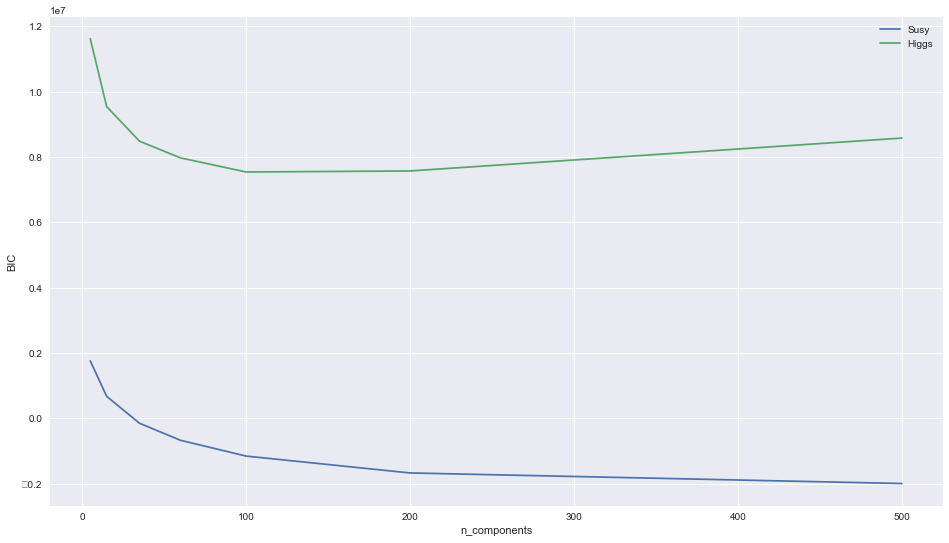

In [96]:
plt.figure(figsize=(16, 9))
plt.plot(components, bics_susy, label='Susy')
plt.plot(components, bics_higgs, label='Higgs')
plt.xlabel('n_components')
plt.ylabel('BIC')
plt.legend()
plt.show()